# 1) Music Recommender - Content Based Filtering

One of the most used machine learning algorithms is recommendation systems. A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

  
> Content-based filters predicts what a user likes based on what that particular user has liked in the past. On the other hand, collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked.

### 1) Content-based filters

Recommendations done using content-based recommenders can be seen as a user-specific classification problem. This classifier learns the user's likes and dislikes from the features of the song.

The most straightforward approach is **keyword matching**.

In a few words, the idea behind is to extract meaningful keywords present in a song description a user likes, search for the keywords in other song descriptions to estimate similarities among them, and based on that, recommend those songs to the user.
  
We'll go through the steps for generating a **content-based** music recommender system.

*Importing Libraries and [Dataset](https://www.kaggle.com/datasets/sujaykapadnis/spotify-songs)*


In [ ]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("server_Z5R5QXV7FECLNJJC3ZRFJ36N-6XEY6GYKJ4DHLXXV")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45227 sha256=a45e6499ee50db1bb9431654b257ae03b761965843a4bfbb2776a7b91706f2ce
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tracks = pd.read_csv('/content/drive/MyDrive/spotify_songs.csv')
tracks.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


*Data Cleaning*

Data Cleaning is one of the important steps without which data will be of no use because the raw data contains a lot of noises that must be removed else the observations made from it will be inaccurate and if we are building a model upon it then it's performance will be poor as well.

In [ ]:
tracks.shape

(32833, 23)

In [ ]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [ ]:
tracks.isnull().sum()
# tracks.isnull().sum().plot.bar()
# plt.show()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

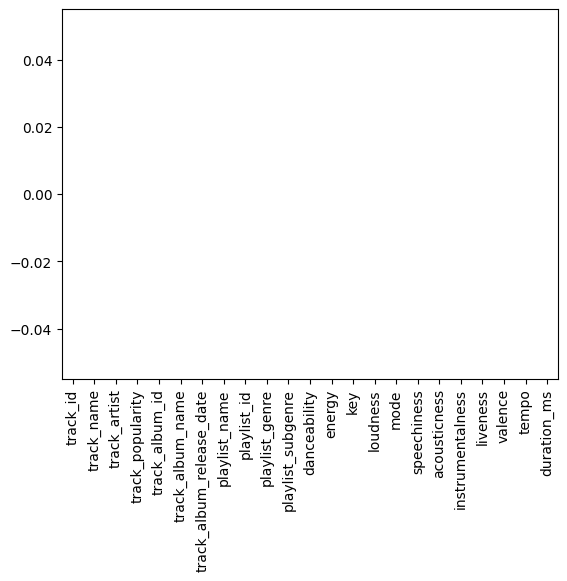

In [ ]:
tracks.dropna(inplace=True)
# tracks.isnull().sum()
tracks.isnull().sum().plot.bar()
plt.show()

In [ ]:
tracks = tracks.drop(
    ['track_id', 'track_album_id', 'playlist_name', 'playlist_id'], axis=1)

In [ ]:
tracks.columns

Index(['track_name', 'track_artist', 'track_popularity', 'track_album_name',
       'track_album_release_date', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [ ]:
tracks['track_name'].nunique(), tracks.shape

(23449, (32828, 19))

Dropping duplicate songs and visualizing count of songs in each decade

In [ ]:
tracks = tracks.sort_values(by=['track_popularity'], ascending=False)
tracks.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

<Axes: xlabel='track_album_release_decade', ylabel='count'>

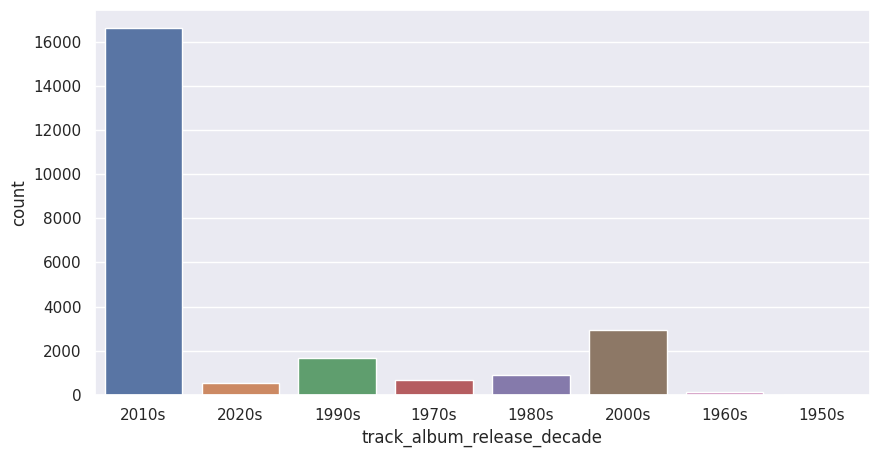

In [ ]:
def get_decade(date):
    year = re.search(r"^(\d+)", date).group()
    period_start = int(int(year)/10) * 10
    decade = '{}s'.format(period_start)
    return decade
plt.figure(figsize = (10, 5))
tracks['track_album_release_decade'] = tracks['track_album_release_date'].apply(get_decade)
sb.set(rc={'figure.figsize':(11 ,6)})
sb.countplot(tracks[['track_album_release_decade']], x='track_album_release_decade')

# Exploratory Data Analysis (EDA)
Finding total no of columns of Float datatype and visualizing distribution plot to get insights into the distribution of the data.

In [ ]:
floats = []
for col in tracks.columns:
  if tracks[col].dtype == 'float':
	  floats.append(col)

len(floats)

9

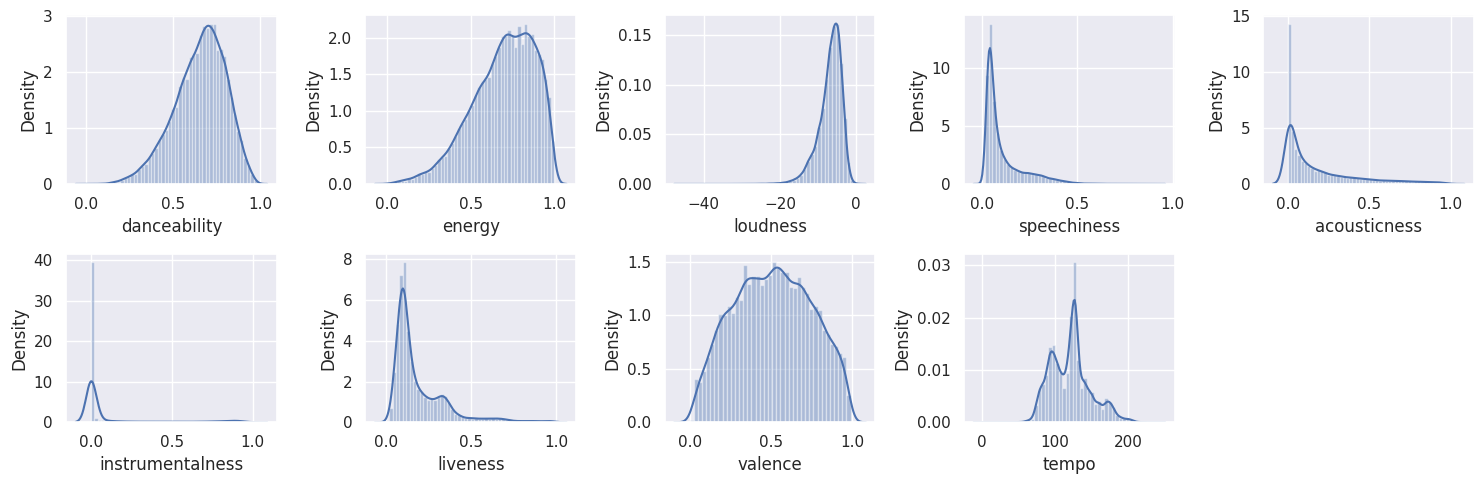

In [ ]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(tracks[col])
plt.tight_layout()
plt.show()

Converting playlist_genre column(textual data) to numerical vector and Taking top 10,000 popular songs

In [ ]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['playlist_genre'])


In [ ]:
tracks = tracks.sort_values(by=['track_popularity'], ascending=False).head(5000)

Get Similarities for input song and each song in dataset
- Get vector(textual - playlist_genre and numeric - float dtype columns) for input song
- For each song, get vector and find cosine similarity between that song's and input song's vectors
- Sum both similarities


- Sort dataset with similarity factor and popularity, so that tracks include popular and similar songs


In [ ]:
def get_similarities(song_name, data):
    # Getting vector for the input song.
    text_array1 = song_vectorizer.transform(data[data['track_name']==song_name]['playlist_genre']).toarray()
    num_array1 = data[data['track_name']==song_name].select_dtypes(include=np.number).to_numpy()

    # We will store similarity for each row of the dataset.
    sim = []
    for idx, row in data.iterrows():
        name = row['track_name']
        # Getting vector for current song.
        text_array2 = song_vectorizer.transform(data[data['track_name']==name]['playlist_genre']).toarray()
        num_array2 = data[data['track_name']==name].select_dtypes(include=np.number).to_numpy()
        # Calculating similarities for text as well as numeric features
        text_sim = cosine_similarity(text_array1, text_array2)[0][0]
        num_sim = cosine_similarity(num_array1, num_array2)[0][0]
        sim.append(text_sim + num_sim)
    return sim

In [ ]:
@anvil.server.callable
def recommend_songs(song_name, data=tracks):
    # Base case
    if tracks[tracks['track_name'] == song_name].shape[0] == 0:
        print('This song is either not so popular or you have entered invalid_name.\n Some songs you may like:\n')
        for song in data.sample(n=5)['track_name'].values:
            print(song)
        return

    data['similarity_factor'] = get_similarities(song_name, data)

    data.sort_values(by=['similarity_factor', 'track_popularity'],
				ascending = [False, False],
				inplace=True)

    #First song will be input song, so sliced indices

    output = ""
    for _, row in data[['track_name', 'track_popularity', 'playlist_genre']][2:7].iterrows():
        output += f"Track: {row['track_name']}\nPopularity: {row['track_popularity']}\nGenre: {row['playlist_genre']}\n\n"

    return output

In [ ]:
import random
@anvil.server.callable
def get_song_names_content():
    # Select 10 random song names from the dataset
    random_songs = tracks['track_name'].sample(n=10)
    return '\n'.join(random_songs)

In [ ]:
print(recommend_songs('Memories - Dillon Francis Remix'))

Track: LALALAY 날라리
Popularity: 70
Genre: pop

Track: Wolves
Popularity: 82
Genre: pop

Track: Dancin (feat. Luvli) - Krono Remix
Popularity: 84
Genre: pop

Track: Love You Better
Popularity: 67
Genre: pop

Track: 2 / 14
Popularity: 67
Genre: pop




In [ ]:
# print(recommend_songs('Wolves'))
print(get_song_names_content())

Viva La Vida
Wheel in the Sky
Strip That Down (feat. Quavo)
Hot Blood
Faucet Failure
Piece Of Your Heart - Alok Remix
Por Ley
DONTTRUSTME
Don't Stop The Music
Fin De Semana


In [ ]:
anvil.server.wait_forever()

KeyboardInterrupt: ignored